# TODO: Title

# Finetune a pretrained image classification CNN to classify dog breed

**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need

!pip install smdebug

  Preparing metadata (setup.py) ... done
  Created wheel for pyinstrument-cext: filename=pyinstrument_cext-0.2.4-cp311-cp311-linux_x86_64.whl size=6415 sha256=7d58ac8b6728fdcbd625567857f6d1117311372d64f60ef658647ed2e9ab0036
  Stored in directory: /home/sagemaker-user/.cache/pip/wheels/6c/d4/b3/f7bd451cdb774b086ee5c4791eff9a667fb197759f2f691f66
Successfully built pyinstrument-cext
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


In [158]:
# TODO: Import any packages that you might need

import os
import json
import time
from PIL import Image
from IPython import display

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorch, PyTorchModel, PyTorchPredictor
from sagemaker.tuner import ContinuousParameter, CategoricalParameter, IntegerParameter, HyperparameterTuner
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.debugger import (
    Rule,
    ProfilerRule,
    DebuggerHookConfig,
    TensorBoardOutputConfig,
    CollectionConfig,
    rule_configs,
)
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.


- i am using the dogImages.zip file suggested by the project guidelines
- there are 133 classes of dog breed
- there are a total of 8351 images, split into 3 datasets: train, validation, and test


In [6]:
#TODO: Fetch and upload the data to AWS S3

!wget --no-check-certificate https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

--2024-12-11 20:25:39--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.216.64, 52.219.116.160, 52.219.112.232, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.216.64|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  45.2MB/s    in 24s     

2024-12-11 20:26:04 (44.6 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



In [7]:
!unzip dogImages.zip

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg  
   creating: dogImages/test/002.Afghan_hound/
  inflating: dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg  
  inflating: dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg  
  inflating: dogImages/test/002.Afghan_hound/Afghan_ho

In [ ]:
#!aws s3 sync s3://mchan-course-4-project/ dogImages
!aws s3 cp dogImages s3://mchan-course-4-project --recursive

upload: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://mchan-course-4-project/test/001.Affenpinscher/Affenpinscher_00023.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg to s3://mchan-course-4-project/test/001.Affenpinscher/Affenpinscher_00047.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://mchan-course-4-project/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00149.jpg to s3://mchan-course-4-project/test/002.Afghan_hound/Afghan_hound_00149.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg to s3://mchan-course-4-project/test/001.Affenpinscher/Affenpinscher_00071.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00146.jpg to s3://mchan-course-4-project/test/002.Afghan_hound/Afghan_hound_00146.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg to s3://mchan-course-4-project/test/001.Affenpinscher/Affenpinscher_00058.jpg
upload:

In [12]:
# although aws s3 cp output reported 949 files still remained, a check of the s3 bucket confirmed all 8351 images have been uploaded

!aws s3api list-objects-v2 --bucket 'mchan-course-4-project' --query "length(Contents)" --output json


8351


In [13]:
# some data exploration

data_dir = './dogImages'

train_set_count = 0
classes_dict = {}
breeds = {}

for folder_type in os.listdir(data_dir):
    if folder_type == '.DS_Store':
        continue
    for folder_name in os.listdir(data_dir + '/' + folder_type):
        if folder_name == '.DS_Store':
            continue
        if folder_type == 'train':
            class_id, class_name = folder_name.split('.')
            classes_dict[class_id] = {'name': class_name, 'count': 0}
            breeds[class_name] = 0
        for file_name in os.listdir(data_dir + '/' + folder_type + '/' + folder_name):
            if file_name == '.DS_Store':
                continue
            if folder_type == 'train':
                classes_dict[class_id]['count'] += 1
                train_set_count += 1
                breeds[class_name] += 1

print(f'There are {train_set_count} images in the train set, of 133 classes:')
print(json.dumps(classes_dict, indent=4, sort_keys=True))
print(json.dumps(breeds, indent=4, sort_keys=True))

max_v = 0
min_v = 1e3

for n, v in breeds.items():
    if v > max_v:
        max_v = v
        max_n = n
    if v < min_v:
        min_v = v
        min_n = n

print(f'Breed with the loweest number of training images: {min_n} ({min_v})')
print(f'Breed with the highest number of training images: {max_n} ({max_v})')

print("Let's check some image sizes...")
for file_name in os.listdir(data_dir + '/train/133.Yorkshire_terrier'):
    if file_name == '.DS_Store':
        continue
    image = Image.open(data_dir + '/train/133.Yorkshire_terrier/' + file_name)
    width, height = image.size
    print(f"\t{file_name}: {width} x {height}")



There are 6680 images in the train set, of 133 classes:
{
    "001": {
        "count": 64,
        "name": "Affenpinscher"
    },
    "002": {
        "count": 58,
        "name": "Afghan_hound"
    },
    "003": {
        "count": 52,
        "name": "Airedale_terrier"
    },
    "004": {
        "count": 63,
        "name": "Akita"
    },
    "005": {
        "count": 77,
        "name": "Alaskan_malamute"
    },
    "006": {
        "count": 64,
        "name": "American_eskimo_dog"
    },
    "007": {
        "count": 50,
        "name": "American_foxhound"
    },
    "008": {
        "count": 66,
        "name": "American_staffordshire_terrier"
    },
    "009": {
        "count": 34,
        "name": "American_water_spaniel"
    },
    "010": {
        "count": 50,
        "name": "Anatolian_shepherd_dog"
    },
    "011": {
        "count": 66,
        "name": "Australian_cattle_dog"
    },
    "012": {
        "count": 66,
        "name": "Australian_shepherd"
    },
    "013":

Let's show an image from the train set...


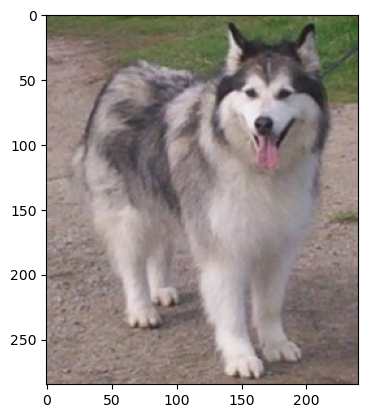

In [14]:
%matplotlib inline

example_image = Image.open('./dogImages/train/005.Alaskan_malamute/Alaskan_malamute_00299.jpg')

print("Let's show an image from the train set...")
plt.imshow(example_image)


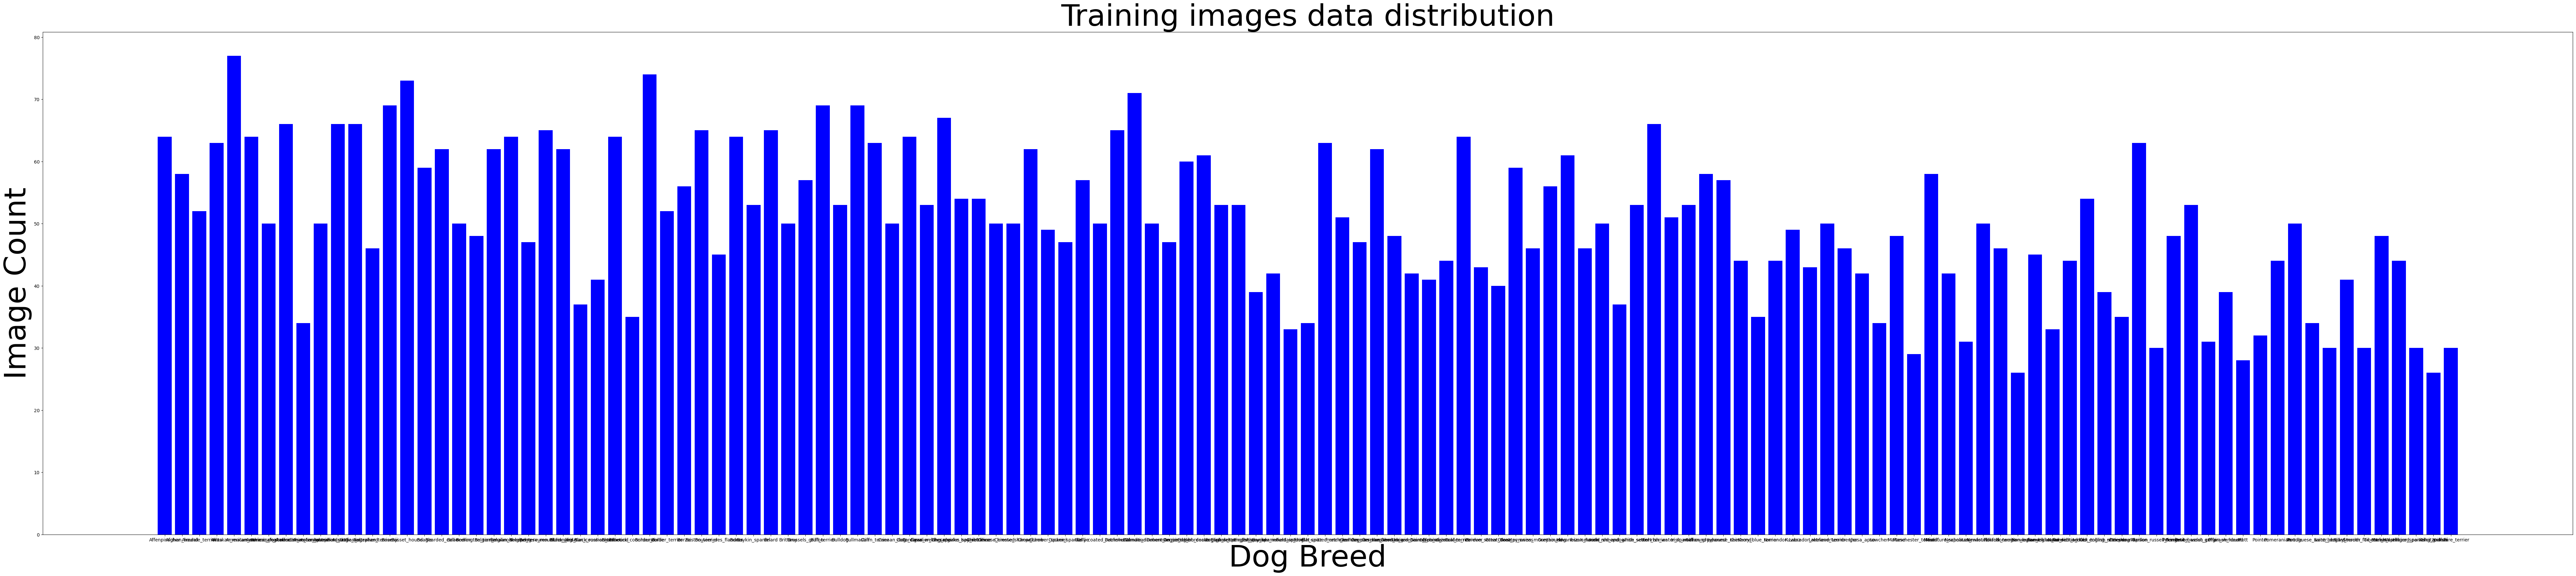

In [15]:
# show training image distribution in a bar graph

fontsize = 66

y = list(breeds.values())
x = list(breeds.keys())

plt.figure(figsize=(100,20))

plt.bar(x, y, color='blue')

plt.title('Training images data distribution', fontsize=fontsize)
plt.xlabel('Dog Breed', fontsize=fontsize)
plt.ylabel('Image Count', fontsize=fontsize)

plt.show()

In [16]:
# check torchvision data loader stuff

import torch
from torchvision import datasets, transforms

train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_image_folder = datasets.ImageFolder('./dogImages/train', train_transforms)
train_data_loader = torch.utils.data.DataLoader(train_image_folder, batch_size=2, shuffle=True, num_workers=4)                                     

/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
# number of batches

len(train_data_loader)

3340

In [18]:
# number of images in the train dataset 

len(train_image_folder)

6680

In [19]:
# also number of images in the train dataset 

len(train_data_loader.dataset)

6680

In [20]:
# train dataset targets/classes

train_image_folder.classes

['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute',
 '006.American_eskimo_dog',
 '007.American_foxhound',
 '008.American_staffordshire_terrier',
 '009.American_water_spaniel',
 '010.Anatolian_shepherd_dog',
 '011.Australian_cattle_dog',
 '012.Australian_shepherd',
 '013.Australian_terrier',
 '014.Basenji',
 '015.Basset_hound',
 '016.Beagle',
 '017.Bearded_collie',
 '018.Beauceron',
 '019.Bedlington_terrier',
 '020.Belgian_malinois',
 '021.Belgian_sheepdog',
 '022.Belgian_tervuren',
 '023.Bernese_mountain_dog',
 '024.Bichon_frise',
 '025.Black_and_tan_coonhound',
 '026.Black_russian_terrier',
 '027.Bloodhound',
 '028.Bluetick_coonhound',
 '029.Border_collie',
 '030.Border_terrier',
 '031.Borzoi',
 '032.Boston_terrier',
 '033.Bouvier_des_flandres',
 '034.Boxer',
 '035.Boykin_spaniel',
 '036.Briard',
 '037.Brittany',
 '038.Brussels_griffon',
 '039.Bull_terrier',
 '040.Bulldog',
 '041.Bullmastiff',
 '042.Cairn_terrier',
 '043.Canaan_do

In [21]:
# check the first batch

for inputs, targets in train_data_loader:
    break

In [22]:
targets

tensor([27, 16])

In [23]:
inputs

tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [-0.3369, -0.2856, -0.5767,  ..., -0.0116, -0.0629, -0.9020],
          [-0.2513,  0.1768, -0.1314,  ...,  0.1254, -0.3541, -0.5596],
          [-0.1657, -0.3541, -0.7308,  ...,  0.0227, -0.4739, -0.2684]],

         [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [ 0.5728,  0.6779,  0.3803,  ...,  0.8529,  0.8004, -0.0399],
          [ 0.7129,  1.1506,  0.8354,  ...,  1.0805,  0.5903,  0.3803],
          [ 0.7304,  0.5553,  0.1702,  ...,  1.0805,  0.5728,  0.7829]],

         [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
          [ 2.6400,  2.6400,  

In [24]:
# check stuff at inference time

import io

# we send image bytes to inference endpoint
with open('./dogImages/test/005.Alaskan_malamute/Alaskan_malamute_00309.jpg', 'rb') as test_image_file:
    image_bytes = test_image_file.read()

print(type(image_bytes))

# custom input_fn convert to jpey file    
input = Image.open(io.BytesIO(image_bytes))

print(type(input))

# custom predict_fn make the same transforms during training and validation
val_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transformed_input = val_transforms(input)

transformed_input

<class 'bytes'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>


tensor([[[ 1.5125,  1.5125,  1.5125,  ..., -1.8439, -1.8953, -1.9295],
         [ 1.5639,  1.5125,  1.5125,  ..., -1.9124, -1.9295, -1.9124],
         [ 1.5810,  1.5468,  1.5297,  ..., -1.9295, -1.9467, -1.9467],
         ...,
         [ 1.4440,  1.4269,  1.3584,  ...,  1.6838,  1.6324,  1.6153],
         [ 1.3755,  1.3242,  1.4269,  ...,  1.6495,  1.6324,  1.6324],
         [ 1.1358,  1.2557,  1.4612,  ...,  1.6153,  1.6667,  1.6495]],

        [[ 1.7983,  1.7983,  1.7983,  ..., -1.7381, -1.7906, -1.8256],
         [ 1.8508,  1.7983,  1.7983,  ..., -1.8081, -1.8256, -1.8256],
         [ 1.8683,  1.8333,  1.8158,  ..., -1.8256, -1.8431, -1.8431],
         ...,
         [ 1.5707,  1.5707,  1.5007,  ...,  1.9209,  1.8683,  1.8859],
         [ 1.5182,  1.4832,  1.5707,  ...,  1.8859,  1.8683,  1.8859],
         [ 1.2381,  1.3782,  1.5882,  ...,  1.8508,  1.9034,  1.8859]],

        [[ 2.2914,  2.3263,  2.3088,  ..., -1.4733, -1.5081, -1.5256],
         [ 2.3437,  2.3088,  2.2914,  ..., -1

In [25]:
# and add a dimension before passing the input to the model
# to match with data loader

ready_input = transformed_input.unsqueeze(0)

ready_input

tensor([[[[ 1.5125,  1.5125,  1.5125,  ..., -1.8439, -1.8953, -1.9295],
          [ 1.5639,  1.5125,  1.5125,  ..., -1.9124, -1.9295, -1.9124],
          [ 1.5810,  1.5468,  1.5297,  ..., -1.9295, -1.9467, -1.9467],
          ...,
          [ 1.4440,  1.4269,  1.3584,  ...,  1.6838,  1.6324,  1.6153],
          [ 1.3755,  1.3242,  1.4269,  ...,  1.6495,  1.6324,  1.6324],
          [ 1.1358,  1.2557,  1.4612,  ...,  1.6153,  1.6667,  1.6495]],

         [[ 1.7983,  1.7983,  1.7983,  ..., -1.7381, -1.7906, -1.8256],
          [ 1.8508,  1.7983,  1.7983,  ..., -1.8081, -1.8256, -1.8256],
          [ 1.8683,  1.8333,  1.8158,  ..., -1.8256, -1.8431, -1.8431],
          ...,
          [ 1.5707,  1.5707,  1.5007,  ...,  1.9209,  1.8683,  1.8859],
          [ 1.5182,  1.4832,  1.5707,  ...,  1.8859,  1.8683,  1.8859],
          [ 1.2381,  1.3782,  1.5882,  ...,  1.8508,  1.9034,  1.8859]],

         [[ 2.2914,  2.3263,  2.3088,  ..., -1.4733, -1.5081, -1.5256],
          [ 2.3437,  2.3088,  

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [95]:
#TODO: Declare your HP ranges, metrics etc.

# i chose learning rate and batch size because:
#   1. they are highly correlated, if we increase the batch size only, the model will perform worse,
#      but if we decrease the learning rate simultaneously, there will be no impact on the performance
# i also chose epochs as the number of passes is also important
# for batch size, i have chosen smaller numbers in my range because:
#   1. our training set is rather small (min 26, max 77)
#   2. updating the model parameters more frequently will give us better generalization
#      which will be less prone to overfitting
# but the downsides of my choices will be:
#   1. it will take longer
#   2. it will cost more

hyperparameter_ranges = {
    'learning_rate': ContinuousParameter(0.0005, 0.005),
    'batch_size': CategoricalParameter([16, 32, 128, 256]),
    'epochs': CategoricalParameter([5, 10])
}

objective_metric_name = 'average test loss'
objective_type = 'Minimize'
metric_definitions = [{"Name": objective_metric_name, "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [96]:
#TODO: Create estimators for your HPs

instance_count = 1
instance_type = 'ml.g4dn.xlarge' # 'ml.m5.large' (basic), 'ml.g4dn.2xlarge' (i don't have permission to use this beefier type)

python_version = 'py36'
pytorch_version = '1.8'

estimator = PyTorch(
    entry_point = './hpo.py',
    base_job_name = 'course4_train_hpo',
    #hyperparameters = hyperparameters,
    framework_version = pytorch_version,
    py_version = python_version,
    role = get_execution_role(),
    instance_count = instance_count,
    instance_type = instance_type
)

tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [97]:
# TODO: Fit your estimator

bucket = 'mchan-course-4-project'

s3_uri = 's3://' + bucket

os.environ['SM_CHANNEL_TRAINING'] = s3_uri
os.environ['SM_MODEL_DIR'] = s3_uri + '/model/'
os.environ['SM_OUTPUT_DATA_DIR'] = s3_uri + '/output/'

tuner.fit({"training": s3_uri}, wait=True)
#tuner.fit(wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................................................................................................................................!


In [98]:
# TODO: Get the best estimators and the best HPs

best_train_job = tuner.best_training_job()
#type(best_train_job) # str
print(best_train_job)

pytorch-training-241212-0639-001-2567c2bc


In [99]:
best_estimator = tuner.best_estimator()
#type(best_estimator) # sagemaker.pytorch.estimator.PyTorch


2024-12-12 06:49:12 Starting - Preparing the instances for training
2024-12-12 06:49:12 Downloading - Downloading the training image
2024-12-12 06:49:12 Training - Training image download completed. Training in progress.
2024-12-12 06:49:12 Uploading - Uploading generated training model
2024-12-12 06:49:12 Completed - Resource reused by training job: pytorch-training-241212-0639-004-1cc03e7b


In [100]:
best_hyperparameters = best_estimator.hyperparameters()
#type(best_hyperparameters) # dict
best_hyperparameters

{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"16"',
 'epochs': '"5"',
 'learning_rate': '0.0006684340499967713',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"course4_train_hpo-2024-12-12-06-39-24-837"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-447842291527/course4_train_hpo-2024-12-12-06-39-24-837/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [101]:
# TODO: Set up debugging and profiling rules and hooks

debug_rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

debug_hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [105]:
# TODO: Create and fit an estimator

actual_hyperparameters = {
    'learning_rate': best_hyperparameters['learning_rate'],
    'batch_size': int(best_hyperparameters['batch_size'].replace('"', '')),
    'epochs': int(best_hyperparameters['epochs'].replace('"', ''))
}

actual_estimator = PyTorch(
    entry_point = './train_model.py',
    base_job_name = 'course4-train',
    hyperparameters = actual_hyperparameters,
    framework_version = pytorch_version,
    py_version = python_version,
    role = get_execution_role(),
    instance_count = instance_count,
    instance_type = instance_type,
    rules = debug_rules,
    debugger_hook_config = debug_hook_config
)

In [130]:
actual_estimator.fit({"training": s3_uri}, wait=True)
#actual_estimator.fit(wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: course4-train-2024-12-12-18-28-24-540


2024-12-12 18:28:24 Starting - Starting the training job...
2024-12-12 18:28:55 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2024-12-12 18:29:26 Downloading - Downloading input data......
2024-12-12 18:30:26 Downloading - Downloading the training image...........................
2024-12-12 18:34:56 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-12-12 18:34:47,673 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-12-12 18:34:47,702 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-12-12 18:34:47,708 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-12-12 18:34:47,990 sagemaker-training-tool

In [131]:
model_artifact_path = actual_estimator.model_data

print(model_artifact_path)

s3://sagemaker-us-east-1-447842291527/course4-train-2024-12-12-18-28-24-540/output/model.tar.gz


In [132]:
# check the rule summary of the latest training job (code from sagemaker examples)

sm_client = actual_estimator.sagemaker_session.sagemaker_client

latest_train_job_name = actual_estimator.latest_training_job.name

latest_train_job_description = sm_client.describe_training_job(TrainingJobName=latest_train_job_name)

while latest_train_job_description["SecondaryStatus"] not in {"Stopped", "Completed"}:

    latest_train_job_description = sm_client.describe_training_job(TrainingJobName=latest_train_job_name)

    primary_status = latest_train_job_description["TrainingJobStatus"]
    secondary_status = latest_train_job_description["SecondaryStatus"]

    print("====================================================================")
    print("TrainingJobStatus: ", primary_status, " | SecondaryStatus: ", secondary_status)
    print("====================================================================")

    for r in range(len(actual_estimator.latest_training_job.rule_job_summary())):

        rule_summary = actual_estimator.latest_training_job.rule_job_summary()

        print(
            rule_summary[r]["RuleConfigurationName"], ": ", rule_summary[r]["RuleEvaluationStatus"]
        )

        if rule_summary[r]["RuleEvaluationStatus"] == "IssuesFound":
            print(rule_summary[r]["StatusDetails"])

    #display.clear_output(wait=True)

    print('Going to sleep 100 secs, and check again...')
    time.sleep(100)

print('Latest training job has either stopped or completed!')

for r in range(len(actual_estimator.latest_training_job.rule_job_summary())):

    rule_summary = actual_estimator.latest_training_job.rule_job_summary()

    print(
        rule_summary[r]["RuleConfigurationName"], ": ", rule_summary[r]["RuleEvaluationStatus"]
    )

    if rule_summary[r]["RuleEvaluationStatus"] == "IssuesFound":
        print(rule_summary[r]["StatusDetails"])

Latest training job has either stopped or completed!
VanishingGradient :  NoIssuesFound
Overfit :  NoIssuesFound
Overtraining :  NoIssuesFound
PoorWeightInitialization :  IssuesFound
RuleEvaluationConditionMet: Evaluation of the rule PoorWeightInitialization at step 0 resulted in the condition being met

ProfilerReport :  IssuesFound
RuleEvaluationConditionMet: Evaluation of the rule ProfilerReport at step 9 resulted in the condition being met



In [133]:
# prepare to plot debug tensors

# create a trial object which represents a single training run
# (with the path of debug artifacts (of the latest training job)

trial = create_trial(actual_estimator.latest_job_debugger_artifacts_path())

[2024-12-12 18:52:02.005 default:166 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-447842291527/course4-train-2024-12-12-18-28-24-540/debug-output


In [134]:
# get a list of tensors recorded

trial.tensor_names()

[2024-12-12 18:52:06.541 default:166 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-12-12 18:52:07.555 default:166 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.bias',
 'gradient/ResNet_fc.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [135]:
# check # of steps saved during diff phase

our_tensor_name = 'CrossEntropyLoss_output_0' #'NLLLoss_output_0'

train_saved_step_count = len(trial.tensor(our_tensor_name).steps(mode=ModeKeys.TRAIN))
val_saved_step_count = len(trial.tensor(our_tensor_name).steps(mode=ModeKeys.EVAL))

print(train_saved_step_count, val_saved_step_count)

24 6


In [136]:
def get_data(trial, tensor_name, mode):
    tensor = trial.tensor(tensor_name)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")

    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


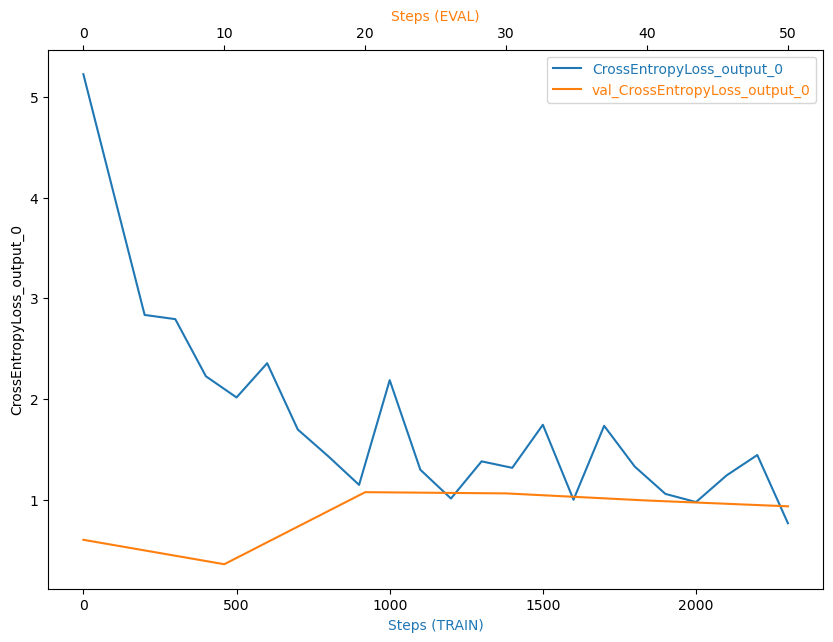

In [137]:
# TODO: Plot a debugging output.

plot_tensor(trial, our_tensor_name)

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

- Debugger has reported an issue with poor weight initialization.

- usually transfer learning does not have problem with poor weight initialization, may be there is domain
  mismatch between the pretrained set and our training set. 

- a remedy is to use standard initialization methods (Xavier, He), with the consideration of network depth.

In [138]:
# prep for showing the profiler report

# put together the rule output S3 path 

rule_output_path = actual_estimator.output_path + latest_train_job_name + "/rule-output"

In [139]:
print(rule_output_path)

s3://sagemaker-us-east-1-447842291527/course4-train-2024-12-12-18-28-24-540/rule-output


In [140]:
# list files in rule output S3 path

!aws s3 ls {rule_output_path} --recursive

2024-12-12 18:39:32     370281 course4-train-2024-12-12-18-28-24-540/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-12-12 18:39:32     219041 course4-train-2024-12-12-18-28-24-540/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-12-12 18:39:27        549 course4-train-2024-12-12-18-28-24-540/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-12-12 18:39:27       5047 course4-train-2024-12-12-18-28-24-540/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-12-12 18:39:27        126 course4-train-2024-12-12-18-28-24-540/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-12-12 18:39:27        130 course4-train-2024-12-12-18-28-24-540/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-12-12 18:39:27       1323 course4-train-2024-12-12-18-28-24-540/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.js

In [141]:
# download files from rule output S3 path

#!aws s3 cp {rule_output_path} ./ --recursive
report_path = rule_output_path + '/ProfilerReport/profiler-output'
!aws s3 cp {report_path} ./profiler-output --recursive

download: s3://sagemaker-us-east-1-447842291527/course4-train-2024-12-12-18-28-24-540/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-447842291527/course4-train-2024-12-12-18-28-24-540/rule-output/ProfilerReport/profiler-output/profiler-report.html to profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-447842291527/course4-train-2024-12-12-18-28-24-540/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-447842291527/course4-train-2024-12-12-18-28-24-540/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-447842291527/course4-train-2024-12-12-18-28-24-540/rule-output/ProfilerReport/profiler-output/profiler-reports/Ov

In [142]:
# get folder name of the profiler report

profiler_report_name = None

for rule in actual_estimator.latest_training_job.rule_job_summary():
    rule_config_name = rule["RuleConfigurationName"]
    print(f"DEBUG: rule config name = '{rule_config_name}'")
    if "Profiler" in rule_config_name:
        print('DEBUG: found profiler report name!')
        profiler_report_name = rule_config_name
        break

print(profiler_report_name)

DEBUG: rule config name = 'VanishingGradient'
DEBUG: rule config name = 'Overfit'
DEBUG: rule config name = 'Overtraining'
DEBUG: rule config name = 'PoorWeightInitialization'
DEBUG: rule config name = 'ProfilerReport'
DEBUG: found profiler report name!
ProfilerReport


In [143]:
# TODO: Display the profiler output

import IPython

IPython.display.HTML(filename="./profiler-output/profiler-report.html")

## Model Deploying

In [149]:
# TODO: Deploy your model to an endpoint

class OurPyTorchPredictor(PyTorchPredictor):
    def __init__(self, endpoint_name, sagemaker_session=None):
        super(OurPyTorchPredictor, self).__init__(
            endpoint_name,
            sagemaker_session,
            serializer=IdentitySerializer("image/jpeg"),
            deserializer=JSONDeserializer()
        )

pytorch_model = PyTorchModel(
    model_data=model_artifact_path,
    entry_point='./inference.py', # model hosting entry point, where we can override default inference handler
    predictor_cls=OurPyTorchPredictor, # deploy() will call this function to create a predictor
    framework_version=pytorch_version,
    py_version=python_version,
    role=get_execution_role(),
    sagemaker_session=sagemaker.Session()
)

In [156]:
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large'
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-447842291527/course4-train-2024-12-12-18-28-24-540/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-447842291527/pytorch-inference-2024-12-12-19-32-52-484/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-12-13-21-50-22-485
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-12-13-21-50-23-238
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-12-13-21-50-23-238


-------!

In [159]:
# TODO: Run an prediction on the endpoint

with open('./dogImages/test/005.Alaskan_malamute/Alaskan_malamute_00309.jpg', 'rb') as image_file:
    payload = image_file.read()

inference = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})

print('Inference response: ')
print(inference)

max_index = np.argmax(inference)

prediction_probability = inference[0][max_index]

prediction_class = classes_dict[f"{max_index+1:03d}"]["name"]

print(f'Predicted breed: {prediction_class} ({prediction_probability})')

Inference response: 
[[-16.88985252380371, -11.904844284057617, -13.96640682220459, -2.034420967102051, 5.847194194793701, -7.3431291580200195, -12.244020462036133, -12.007404327392578, -14.02337646484375, -6.31516695022583, -11.889496803283691, -7.918485641479492, -18.13979721069336, -9.012372970581055, -14.113032341003418, -8.357064247131348, -11.16773796081543, -12.34010124206543, -12.292344093322754, -10.248825073242188, -11.6373291015625, -9.89365291595459, -13.545564651489258, -12.685131072998047, -16.143177032470703, -15.830399513244629, -14.918481826782227, -16.17563819885254, -10.791664123535156, -15.195769309997559, -5.4568681716918945, -11.883410453796387, -11.567770957946777, -15.341170310974121, -17.720558166503906, -16.325429916381836, -14.668110847473145, -16.29121208190918, -13.505875587463379, -13.109651565551758, -16.38774299621582, -14.153411865234375, -7.035895347595215, -13.714139938354492, -5.921092510223389, -14.041169166564941, -13.636736869812012, -10.140470504

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

predictor.delete_endpoint()